<a href="https://colab.research.google.com/github/himanshu131098/Authentication-Security/blob/master/Project_ME8813_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anomaly Detection in the Power Transformers of Nuclear Power Plants using Multiclass classifier

## Import Python Packages

In [1]:
!pip install tsfresh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.2/136.2 kB 7.4 MB/s eta 0:00:00


In [129]:
!pip install mlxtend --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.9 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
import seaborn as sns
from tsfresh import extract_relevant_features
from tsfresh.feature_extraction import EfficientFCParameters
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from mlxtend.plotting import plot_confusion_matrix

## Import the datasets

In [3]:
X_df = pd.read_csv('X_data.csv')
y_df = pd.read_csv('y_data.csv', index_col=0, header=None).squeeze("columns")
y_df = y_df.tail(-1) 

### Datasets Properties

In [4]:
X_df.shape

(882000, 6)

In [5]:
X_df.sample(5)

,serial,H2,CO,C2H4,C2H2,id
688398,18,0.002715,0.008028,0.002067,0.000131,2770
781464,264,0.001708,0.015973,0.005289,0.000292,1860
505676,416,0.002266,0.016281,0.006095,0.000268,1190
32716,376,0.001846,0.032238,0.011075,0.000230,2585
415862,62,0.002240,0.005959,0.004831,0.000312,744


In the above data we have 6 columns, 4 of them represent the concentration of various gases at a particular time given by the serial column. The id column represents the Power Transformers (PT)  id which is a unique identifier since we have data from many PT's.

In [6]:
y_df.shape

(2100,)

In [7]:
y_df.sample(10)

0
1002.0    1
173.0     1
2521.0    1
2838.0    2
352.0     1
971.0     1
1547.0    1
72.0      1
2330.0    1
1349.0    1
Name: 1, dtype: int64

In the y dataset is a type of Pandas Series Data in which the index is unique id of the PT and the correponding category represents the operation modes which are given as:
- **Mode-01** : Normal Mode
- **Mode-02** : Partal Discharge
- **Mode-03** : Low Energy Discharge
- **Mode-04** : Low-temperature overheating

## Features Extraction 

As we have seen that we have 882000 time series points where the concentration of various gases was recorded. To classify such huge amount data we need to use high computational resources. In addition the concentration of gases may not change significantly. Therefore we need to get some features for every PT's in which can help use build a the multi classifier we intend.

To extract features we use *tsfresh* which is used for systematic feature engineering from time-series and other sequential data. If we do this manually then it will take lot of time and we may not able to get all the features.

One if the most important factor while using the *tsfresh* is the feature extraction settings. We have the following options:

- **tsfresh.feature_extraction.settings.ComprehensiveFCParameters**: includes all features without parameters and all features with parameters, each with different parameter combinations.

- **tsfresh.feature_extraction.settings.MinimalFCParameters**: includes only a handful of features and can be used for quick tests. The features which have the “minimal” attribute are used here.

- **tsfresh.feature_extraction.settings.EfficientFCParameters**: Mostly the same features as in the tsfresh.feature_extraction.settings.ComprehensiveFCParameters, but without features which are marked with the “high_comp_cost” attribute. This can be used if runtime performance plays a major role.

For our case we use the *tsfresh.feature_extraction.settings.EfficientFCParameters* one to get efficient parameters efficiently.

In [8]:
extraction_settings = EfficientFCParameters()

In [9]:
X_filt_df = extract_relevant_features(X_df, y_df, column_id='id', column_sort='serial',
                                         default_fc_parameters=extraction_settings)

Feature Extraction: 100%|██████████| 8400/8400 [17:48<00:00,  7.86it/s]


In [10]:
X_filt_df.shape 

(2100, 2549)

In [71]:
y_df.shape

(2100,)

In [11]:
X_filt_df.sample(5)

,CO__quantile__q_0.9,CO__quantile__q_0.8,CO__c3__lag_1,CO__c3__lag_2,CO__c3__lag_3,CO__root_mean_square,CO__abs_energy,CO__mean_n_absolute_max__number_of_maxima_7,CO__maximum,CO__absolute_maximum,...,"C2H4__fft_aggregated__aggtype_""kurtosis""","C2H4__fft_aggregated__aggtype_""skew""",C2H4__ar_coefficient__coeff_10__k_10,CO__ratio_beyond_r_sigma__r_3,"C2H4__fft_aggregated__aggtype_""centroid""",C2H4__fourier_entropy__bins_3,"C2H4__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.0","CO__change_quantiles__f_agg_""mean""__isabs_True__qh_0.6__ql_0.4",CO__ar_coefficient__coeff_7__k_10,H2__energy_ratio_by_chunks__num_segments_10__segment_focus_4
679,0.031664,0.031591,2.921748e-05,2.921657e-05,2.921594e-05,0.030793,0.398238,0.031771,0.031874,0.031874,...,46.987930,6.398671,-0.129356,0.0,4.327316,0.090729,4.808395e-12,0.000024,0.263635,0.098617
1710,0.037869,0.033757,2.495554e-05,2.486912e-05,2.478344e-05,0.028583,0.343132,0.041999,0.042316,0.042316,...,6.208912,1.938123,-0.162708,0.0,30.603817,0.045395,1.594912e-11,0.000047,2.115098,0.013621
951,0.024176,0.022728,1.077714e-05,1.076078e-05,1.074430e-05,0.022044,0.204095,0.026118,0.026237,0.026237,...,18.697192,3.923746,-0.078901,0.0,10.485057,0.090729,7.590964e-12,0.000028,0.604455,0.083395
354,0.039182,0.034382,2.969806e-05,2.958958e-05,2.948202e-05,0.030518,0.391156,0.044309,0.044692,0.044692,...,29.384875,5.005715,-0.086097,0.0,6.813078,0.090729,6.537446e-12,0.000012,0.084152,0.106453
988,0.010614,0.009222,5.269211e-07,5.246175e-07,5.223507e-07,0.007792,0.025501,0.012329,0.012469,0.012469,...,8.964957,2.547468,-0.059338,0.0,20.938298,0.045395,1.049948e-11,0.000017,0.415038,0.100217


We have 2549 features and 2100 datapoints after feature extraction. However still these are lot of features. So we will use the **Pearson Coefficient** to drop the features with high correlation.

###  Creating the Correlation matrix and Selecting the Upper triangular matrix

In [12]:
X_filt_corr = X_filt_df.corr().abs()

In [13]:
X_filt_corr.shape

(2549, 2549)

Select the upper triangular part of the matrix excluding the diagonals.

In [14]:
upper_tri = X_filt_corr.where(np.triu(np.ones(X_filt_corr.shape),k=1).astype(bool))

In [15]:
upper_tri

,CO__quantile__q_0.9,CO__quantile__q_0.8,CO__c3__lag_1,CO__c3__lag_2,CO__c3__lag_3,CO__root_mean_square,CO__abs_energy,CO__mean_n_absolute_max__number_of_maxima_7,CO__maximum,CO__absolute_maximum,...,"C2H4__fft_aggregated__aggtype_""kurtosis""","C2H4__fft_aggregated__aggtype_""skew""",C2H4__ar_coefficient__coeff_10__k_10,CO__ratio_beyond_r_sigma__r_3,"C2H4__fft_aggregated__aggtype_""centroid""",C2H4__fourier_entropy__bins_3,"C2H4__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.0","CO__change_quantiles__f_agg_""mean""__isabs_True__qh_0.6__ql_0.4",CO__ar_coefficient__coeff_7__k_10,H2__energy_ratio_by_chunks__num_segments_10__segment_focus_4
CO__quantile__q_0.9,NaN,0.992454,0.888851,0.888552,0.888253,0.972910,0.935034,0.994561,0.993780,0.993780,...,0.043339,0.064932,0.020939,0.064871,0.046382,0.026024,0.048228,0.212508,0.124767,0.033570
CO__quantile__q_0.8,NaN,NaN,0.908983,0.908841,0.908697,0.991841,0.958486,0.974816,0.973225,0.973225,...,0.040188,0.058535,0.018625,0.064482,0.039461,0.015860,0.032192,0.184014,0.092860,0.021926
CO__c3__lag_1,NaN,NaN,NaN,0.999999,0.999995,0.913505,0.984055,0.861130,0.858854,0.858854,...,0.015257,0.028884,0.005031,0.040409,0.024246,0.034876,0.022178,0.131921,0.074617,0.014829
CO__c3__lag_2,NaN,NaN,NaN,NaN,0.999999,0.913528,0.984108,0.860712,0.858428,0.858428,...,0.015216,0.028816,0.005008,0.040222,0.024189,0.034781,0.022027,0.131257,0.074246,0.014727
CO__c3__lag_3,NaN,NaN,NaN,NaN,NaN,0.913549,0.984158,0.860293,0.858001,0.858001,...,0.015175,0.028749,0.004987,0.040034,0.024132,0.034683,0.021875,0.130592,0.073876,0.014624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C2H4__fourier_entropy__bins_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.066986,0.108324,0.006296,0.048827
"C2H4__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.0",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.056766,0.024196,0.076264
"CO__change_quantiles__f_agg_""mean""__isabs_True__qh_0.6__ql_0.4",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.106345,0.030114
CO__ar_coefficient__coeff_7__k_10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.042752


### Droping the column with a high correlation

In [16]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] >= 0.90)]

In [17]:
len(to_drop)

2186

In [18]:
X_filt_df.drop(to_drop, axis=1, inplace=True)

In [19]:
X_filt_df.shape

(2100, 363)

Here we still have 455 features which are a lot to design a multi class classifier. So we will use **Principal Component Analysis** to determine the components which explain 99% variation of data.

## Principal Compoent Analysis

### Standard Scalar 

In [27]:
sc = MinMaxScaler()
X_sc = pd.DataFrame(sc.fit_transform(X_filt_df))

In [28]:
X_sc.describe()

,0,1,2,3,4,5,6,7,8,9,...,353,354,355,356,357,358,359,360,361,362
count,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,...,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000
mean,0.400847,0.110503,0.013581,0.941822,0.937677,0.353278,0.935562,0.752256,0.086667,0.514910,...,0.528877,0.701774,0.681429,0.530984,0.007707,0.044021,0.572066,0.078059,0.128953,0.290876
std,0.213082,0.129394,0.032218,0.194305,0.200177,0.202960,0.199153,0.218641,0.281413,0.201478,...,0.111669,0.082516,0.466033,0.225482,0.036175,0.057021,0.074399,0.183822,0.239633,0.080809
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.236754,0.018349,0.006562,1.000000,1.000000,0.187915,1.000000,0.697332,0.000000,0.351513,...,0.464490,0.704276,0.000000,0.375250,0.001414,0.017901,0.541401,0.000000,0.000000,0.259097
50%,0.408284,0.063524,0.011216,1.000000,1.000000,0.337992,1.000000,0.842333,0.000000,0.516342,...,0.537611,0.717906,1.000000,0.530308,0.002990,0.031771,0.572749,0.000000,0.000000,0.305026
75%,0.564425,0.152785,0.015356,1.000000,1.000000,0.501620,1.000000,0.897316,0.000000,0.678130,...,0.601212,0.726811,1.000000,0.699579,0.005686,0.050474,0.607706,0.000000,0.000000,0.339063
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### PCA

In [59]:
# 95% of variance
pca = PCA(n_components=95)
pca.fit(X_sc)
cum_sum = np.cumsum(pca.explained_variance_ratio_)
ind_95_var = np.argmax(cum_sum > 0.95)
pca_df = pd.DataFrame(pca.transform(X_sc))

In [58]:
print(f"The number of components explaining 95% variance are {ind_95_var}. ")

The number of components explaining 95% variance are 94. 


In [60]:
pca_df.shape

(2100, 95)

In [61]:
pca_df.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,94
562,-1.323413,-0.458577,-0.309993,0.785605,-0.181218,0.295079,-0.569440,-0.938859,-0.543243,1.170902,...,0.039427,0.089400,-0.131106,0.029291,-0.003139,0.106824,0.121187,0.048059,-0.073299,0.025330
1166,-0.532332,1.172244,-1.136705,-1.284419,0.493396,-0.115136,0.285300,-0.177071,-0.879482,-0.883183,...,0.104947,0.016240,0.027065,-0.005002,-0.064925,0.039482,-0.190155,0.035471,-0.096528,0.024556
176,-1.302989,0.241173,0.139408,-0.346067,-0.936919,-0.495712,-0.587102,-0.511987,-0.736871,0.928024,...,0.058697,0.113379,-0.020234,0.022882,-0.075299,-0.096589,0.062824,-0.119208,0.024554,-0.054000
871,-0.298174,-0.596944,0.189628,-1.040165,1.046834,0.125316,0.101922,0.839800,-1.177201,-0.106858,...,0.127693,-0.052059,0.091510,-0.006379,-0.065036,0.087737,0.112415,0.129279,0.346302,-0.116817
1057,0.250930,-0.044222,1.891937,0.219888,0.385253,0.698696,1.279095,0.162660,0.543077,0.161658,...,0.008312,-0.006070,-0.029413,-0.080425,-0.088671,0.102486,0.029879,0.176982,0.014053,0.050513


### Cumulative Proportion Variance

In [62]:
out_sum = np.cumsum(pca.explained_variance_ratio_)  
print ("Cumulative Prop. Variance Explained: ", out_sum)

Cumulative Prop. Variance Explained:  [0.14530271 0.24462454 0.30094851 0.35241491 0.39804617 0.44212902
 0.47695846 0.50565902 0.53187786 0.55388872 0.57414225 0.59242779
 0.60810215 0.62301832 0.63771106 0.65016232 0.66193501 0.67365817
 0.68495375 0.6959716  0.70622577 0.71619365 0.72552791 0.73424032
 0.74279984 0.75115177 0.75883519 0.76608302 0.77286054 0.77918508
 0.7853373  0.79126741 0.79702626 0.80275168 0.80814565 0.81342607
 0.81860737 0.82361833 0.82836185 0.83287532 0.83736503 0.84175869
 0.84584166 0.84984228 0.85372951 0.85748272 0.86111872 0.86465963
 0.86818427 0.87155377 0.87486138 0.87805772 0.88109289 0.88397897
 0.88678987 0.88939134 0.89192328 0.89435749 0.89668567 0.89898192
 0.90124131 0.90339033 0.90547036 0.90752453 0.90949121 0.91143957
 0.91336894 0.91522513 0.91705475 0.91877977 0.92046197 0.92208711
 0.92369149 0.92526666 0.92681727 0.92831558 0.9297719  0.93121638
 0.93258234 0.93392556 0.93522962 0.93651738 0.93776672 0.93898179
 0.94015173 0.94129043 0

### Save the dataframe of 94 features for further use.

In [72]:
pca_df.to_csv('pca_feat_x.csv')
y_df.to_csv('pca_feat_y.csv')

## Classification Algorithms 

The goal of this section is to test different classification algorithms with the features obtained after principal component analysis in the above section. From this classifier models we will select the top models to develop the final stacked multi-class classifier.

### Importing the dataset

In [2]:
X = pd.read_csv('pca_feat_x.csv')
y = pd.read_csv('pca_feat_y.csv')
y = y.iloc[:,-1]

In [3]:
X.shape

(2100, 96)

In [4]:
y.shape

(2100,)

### Split the data into training and test set

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

### Decision Tree Classification model 

In [6]:
classifier = DecisionTreeClassifier(criterion='entropy', random_state=0)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

#### Classification Report

In [7]:
y_pred = classifier.predict(X_test)

In [8]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.79      0.77      0.78       340
           2       0.04      0.07      0.05        14
           3       0.10      0.07      0.08        30
           4       0.09      0.11      0.10        36

    accuracy                           0.64       420
   macro avg       0.26      0.25      0.25       420
weighted avg       0.66      0.64      0.65       420



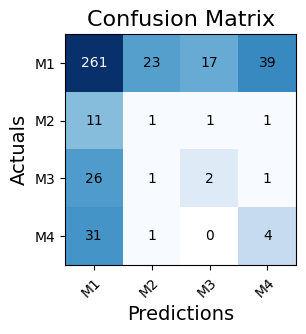

In [12]:
conf_matrix = confusion_matrix(y_test, y_pred)
class_names = ['M1', 'M2', 'M3', 'M4']
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, 
                                figsize=(3, 3), 
                                norm_colormap=LogNorm() ,
                                class_names=class_names,
                                )
plt.xlabel('Predictions', fontsize=14)
plt.ylabel('Actuals', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

### K-Nearest Neighbors

In [14]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)

KNeighborsClassifier()

#### Classification Report

In [15]:
y_pred = knn.predict(X_test)

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.81      0.99      0.89       340
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00        30
           4       0.50      0.06      0.10        36

    accuracy                           0.81       420
   macro avg       0.33      0.26      0.25       420
weighted avg       0.70      0.81      0.73       420



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


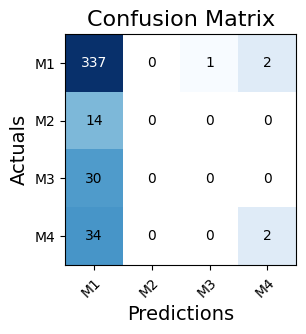

In [17]:
conf_matrix = confusion_matrix(y_test, y_pred)
class_names = ['M1', 'M2', 'M3', 'M4']
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, 
                                figsize=(3, 3), 
                                norm_colormap=LogNorm() ,
                                class_names=class_names,
                                )
plt.xlabel('Predictions', fontsize=14)
plt.ylabel('Actuals', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

### Kernel SVM

In [19]:
svm = SVC(kernel = 'rbf', random_state = 0)
svm.fit(X_train, y_train)

SVC(random_state=0)

#### Classification Report

In [20]:
y_pred = svm.predict(X_test)

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.81      1.00      0.89       340
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00        30
           4       0.00      0.00      0.00        36

    accuracy                           0.81       420
   macro avg       0.20      0.25      0.22       420
weighted avg       0.66      0.81      0.72       420



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


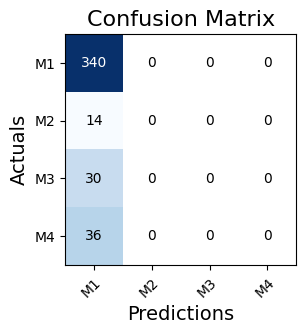

In [22]:
conf_matrix = confusion_matrix(y_test, y_pred)
class_names = ['M1', 'M2', 'M3', 'M4']
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, 
                                figsize=(3, 3), 
                                norm_colormap=LogNorm() ,
                                class_names=class_names,
                                )
plt.xlabel('Predictions', fontsize=14)
plt.ylabel('Actuals', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

#### Classification Report

In [ ]:
y_pred = svm.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.81      1.00      0.89       340
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00        30
           4       0.00      0.00      0.00        36

    accuracy                           0.81       420
   macro avg       0.20      0.25      0.22       420
weighted avg       0.66      0.81      0.72       420



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


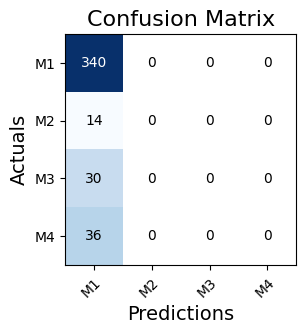

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
class_names = ['M1', 'M2', 'M3', 'M4']
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, 
                                figsize=(3, 3), 
                                norm_colormap=LogNorm() ,
                                class_names=class_names,
                                )
plt.xlabel('Predictions', fontsize=14)
plt.ylabel('Actuals', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

### Logistic Regression

In [24]:
lr_classifier = LogisticRegression(random_state = 0)
lr_classifier.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

#### Classification Report

In [25]:
y_pred = lr_classifier.predict(X_test)

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.81      1.00      0.89       340
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00        30
           4       0.00      0.00      0.00        36

    accuracy                           0.81       420
   macro avg       0.20      0.25      0.22       420
weighted avg       0.66      0.81      0.72       420



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


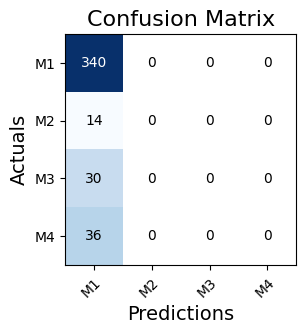

In [27]:
conf_matrix = confusion_matrix(y_test, y_pred)
class_names = ['M1', 'M2', 'M3', 'M4']
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, 
                                figsize=(3, 3), 
                                norm_colormap=LogNorm() ,
                                class_names=class_names,
                                )
plt.xlabel('Predictions', fontsize=14)
plt.ylabel('Actuals', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

### Naive Bayes

In [29]:
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

GaussianNB()

#### Classification Report

In [30]:
y_pred = nb_classifier.predict(X_test)

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.82      0.95      0.88       340
           2       0.09      0.07      0.08        14
           3       0.20      0.03      0.06        30
           4       0.29      0.06      0.09        36

    accuracy                           0.78       420
   macro avg       0.35      0.28      0.28       420
weighted avg       0.70      0.78      0.73       420



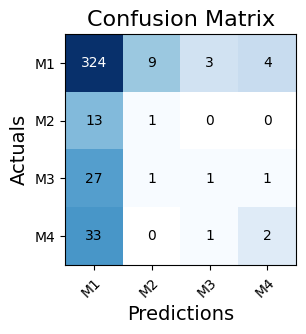

In [32]:
conf_matrix = confusion_matrix(y_test, y_pred)
class_names = ['M1', 'M2', 'M3', 'M4']
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, 
                                figsize=(3, 3), 
                                norm_colormap=LogNorm() ,
                                class_names=class_names,
                                )
plt.xlabel('Predictions', fontsize=14)
plt.ylabel('Actuals', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

### Random Forest 

In [34]:
rf_classifier = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=0)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

#### Classification Report

In [35]:
y_pred = rf_classifier.predict(X_test)

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.81      1.00      0.89       340
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00        30
           4       0.00      0.00      0.00        36

    accuracy                           0.81       420
   macro avg       0.20      0.25      0.22       420
weighted avg       0.66      0.81      0.72       420



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


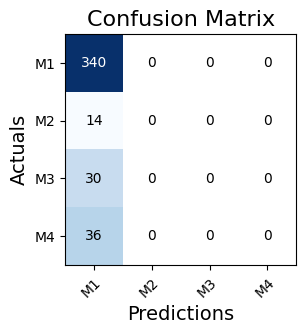

In [37]:
conf_matrix = confusion_matrix(y_test, y_pred)
class_names = ['M1', 'M2', 'M3', 'M4']
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, 
                                figsize=(3, 3), 
                                norm_colormap=LogNorm() ,
                                class_names=class_names,
                                )
plt.xlabel('Predictions', fontsize=14)
plt.ylabel('Actuals', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()